# PyTorch Computer Vision

## 0. Computer vision libraries in PyTorch

* `torchvision`
* `torchvision.datasets`
* `torchvision.models`
* `torchvision.transforms`
* `torch.utils.data.Dataset`
* `torch.utils.data.DataLoader`

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

## 1. Getting a dataset

The dataset we'll be using is `FashionMNIST`

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(root="data",
                                   train = True,
                                   download = True,
                                   transform = ToTensor(),
                                   target_transform = None
                                   )

test_data = datasets.FashionMNIST(root="data",
                                  train = False,
                                  download = True,
                                  transform = ToTensor(),
                                  target_transform = None
                                   )

100%|██████████| 26421880/26421880 [00:03<00:00, 8158012.04it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139852.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2656620.18it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19992849.07it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
image.shape, class_names[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


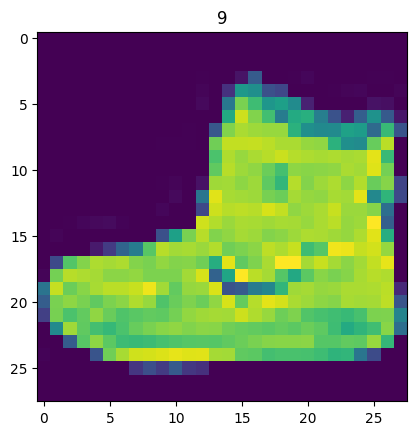

In [9]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze());
plt.title(label);

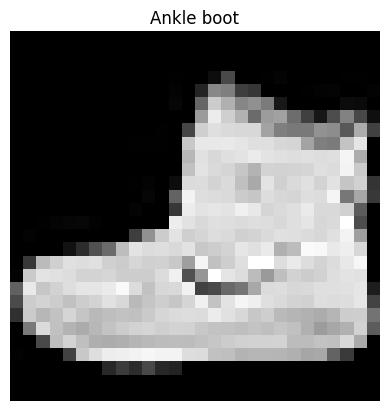

In [10]:
plt.imshow(image.squeeze(), cmap = "gray");
plt.title(class_names[label]);
plt.axis(False);

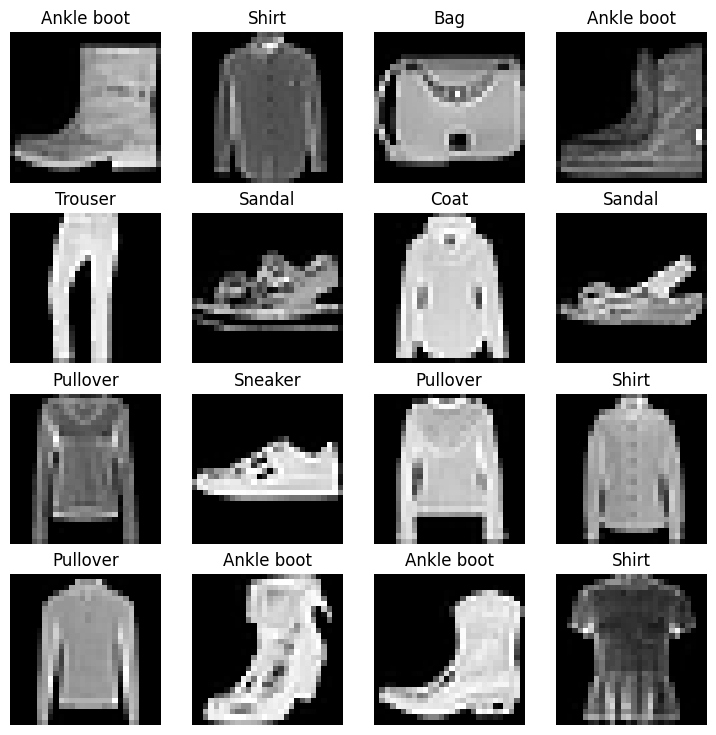

In [11]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize = (9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False)

## 2. Prepare DataLoader

We turn our data into batches (or mini-batches) in order to be more computationally efficient. Common batch size is 32. Also, it gives our neural networks more chances to update its gradients per epoch.

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [14]:
print(f" DataLoaders: {train_dataloader, test_dataloader}")
print(f" Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f" Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

 DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fd33c1374f0>, <torch.utils.data.dataloader.DataLoader object at 0x7fd33c4bbd30>)
 Length of train_dataloader: 1875 batches of 32
 Length of test_dataloader: 313 batches of 32


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

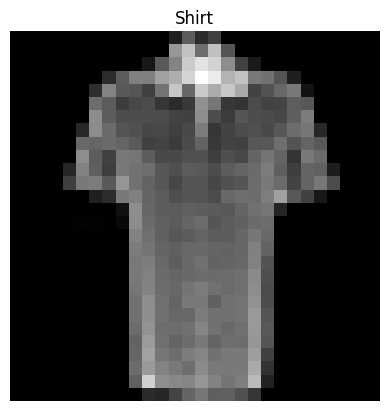

In [16]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(image.squeeze(), cmap = "gray");
plt.title(class_names[label]);
plt.axis(False);

## 3. Model 0: Build a baseline model

A baseline model is a simple model you will try to improve.

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

# Print out what happened
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [19]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape = 784,
                              hidden_units = 10,
                              output_shape = len(class_names)
                              ).cpu()

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1, 1, 28, 28])

model_0.eval()
with torch.inference_mode():
  pred = model_0(dummy_x)

pred

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]])

In [21]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation mode

In [22]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [23]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

### 3.2 Creating a function to time our experiments

In [24]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  '''Prints and returns difference between start and end time.'''
  total_time = end - start
  return total_time
  print(f"Train time on {device}: {total_time:.3f} seconds")


start_time = timer()
# Some code
end_time = timer()

print_train_time(start = start_time,
                 end = end_time)

4.479799999757006e-05

### 3.3 Creating a training and testing loop on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testint steps, calculate the test loss *per batch*
4. Print out what's happening
5. Time it

In [25]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------------------------------")

  # Training
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      test_pred = model_0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss {test_loss:.4f} | Test acc: {test_acc:.2f}%")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                      end = train_time_end_on_cpu,
                                      device = str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss 0.5095 | Test acc: 82.04%
Epoch: 1
--------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss 0.4799 | Test acc: 83.20%
Epoch: 2
--------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss 0.4766 | Test acc: 83.43%


In [26]:
str(next(model_0.parameters()).device)

'cpu'

### 4. Make predictions and get Model_0 results

In [27]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = None):
  """Returns a dictionary containing the results of model predicting on data_loader"""

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": float("{:.4f}".format(loss.item())),
          "model_acc": float("{:.2f}".format(acc))}

model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4766, 'model_acc': 83.43}

## 5. Setup device agnostic code

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

## 6. Model 1

In [29]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [30]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [31]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

### 6.1 Functionizing training and testing loops

* train_step()
* test_step()

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  # Training
    model.train()

    train_loss, train_acc = 0, 0

    # Loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):

      # Put data on target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass -> logits
      y_pred = model(X)

      # 2. Loss and accuracy
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true = y,
                               y_pred = y_pred.argmax(dim = 1)) # logits -> prediction labels

      # 3.
      optimizer.zero_grad()

      # 4.
      loss.backward()

      # 5.
      optimizer.step()

    #
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [33]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc = 0, 0

   # Testing
  model_0.eval()

  with torch.inference_mode():
    for X_test, y_test in data_loader:

      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass -> logits
      test_pred = model(X_test)

      # 2. Loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true = y_test,
                              y_pred = test_pred.argmax(dim = 1)) # logits -> prediction labels

    test_loss /= len(data_loader)

    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [34]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------------------------------")

  train_step(model = model_1,
            data_loader = train_dataloader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            accuracy_fn = accuracy_fn,
            device = device)

  test_step(model = model_1,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                            end = train_time_end_on_gpu,
                                            device = str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------------------------------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
--------------------------------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
--------------------------------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%



In [35]:
print(f"Train time model_0 on cpu: {total_train_time_model_0:.2f} seconds | Train time model_1 on {device}: {total_train_time_model_1:.2f} seconds")

Train time model_0 on cpu: 33.46 seconds | Train time model_1 on cuda: 38.71 seconds


**Note:** Depending on your data/hardware, model could train faster on CPU than GPU.

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms compute capability than the GPU.

In [36]:
# Get model_1 result dictionary
model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device = device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [37]:
model_1_results

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.685, 'model_acc': 75.02}

In [38]:
model_0_results

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4766, 'model_acc': 83.43}

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known ConvNets

CNN's are know for heir capabilities to find patterns in visual data

In [39]:
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the
  TinyVGG model from CNN explainer website.
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7,
                  out_features = output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    return x

In [40]:
image.shape

torch.Size([1, 28, 28])

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

### 7.1 Stepping trough `nn.Conv2d`

In [42]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [43]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 0)

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping trough `nn.MaxPool2d()`

In [44]:
print(f"Test image original shape: {test_image.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size = 2)

test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer and max_pool_layer: {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Shape after going through conv_layer: torch.Size([10, 62, 62])
Shape after going through conv_layer and max_pool_layer: torch.Size([10, 31, 31])


In [45]:
torch.manual_seed(42)
random_tensor = torch.randn(1, 1, 2, 2)
print(f"Random tensor:\n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])


In [46]:
max_pool_layer = nn.MaxPool2d(kernel_size = 2)
random_tensor_through_max_pool_layer = max_pool_layer(random_tensor)
print(f"Random tensor through max poll:\n {random_tensor_through_max_pool_layer}")
print(f"Random tensor through shape: {random_tensor_through_max_pool_layer.shape}")

Random tensor through max poll:
 tensor([[[[0.3367]]]])
Random tensor through shape: torch.Size([1, 1, 1, 1])


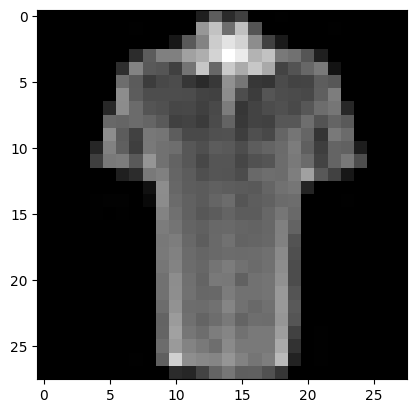

In [47]:
plt.imshow(image.squeeze(), cmap = 'gray')

In [48]:
image.shape

torch.Size([1, 28, 28])

In [49]:
rand_image = torch.randn(1, 28, 28)
rand_image.shape

torch.Size([1, 28, 28])

In [50]:
# model_2(rand_image.to(device))

### 7.3 Setup a loss and optimizer

In [51]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n--------------------------------")
  train_step(model = model_2,
            data_loader = train_dataloader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            accuracy_fn = accuracy_fn,
            device = device
            )

  test_step(model = model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device
            )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                            end = train_time_end_model_2,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------------------------------
Train loss: 0.59223 | Train acc: 78.44%
Test loss: 0.39742 | Test acc: 85.85%

Epoch: 1
--------------------------------
Train loss: 0.36208 | Train acc: 86.91%
Test loss: 0.35082 | Test acc: 86.96%

Epoch: 2
--------------------------------
Train loss: 0.32332 | Train acc: 88.28%
Test loss: 0.32157 | Test acc: 88.26%



In [53]:
print(f"Total train time of model_2 on {device}: {total_train_time_model_0:.2f}")

Total train time of model_2 on cuda: 33.46


In [54]:
# Get model_2 results
model_2_results = eval_model(model = model_2,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn = accuracy_fn,
                            device = device
                            )
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3216, 'model_acc': 88.26}

In [55]:
model_1_results

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.685, 'model_acc': 75.02}

## 8. Compare model results and training time

In [56]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.4766,83.43
1,FashionMNISTModelV1,0.6850,75.02
2,FashionMNISTModelV2,0.3216,88.26


In [57]:
# Add training time to results comparison

total_train_time_model_0, total_train_time_model_1, total_train_time_model_2 = "{:.2f}".format(total_train_time_model_0), "{:.2f}".format(total_train_time_model_1), "{:.2f}".format(total_train_time_model_2)

compare_results["training [s]"] = [total_train_time_model_0,
                                   total_train_time_model_1,
                                   total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training [s]
0,FashionMNISTModelV0,0.4766,83.43,33.46
1,FashionMNISTModelV1,0.6850,75.02,38.71
2,FashionMNISTModelV2,0.3216,88.26,45.50


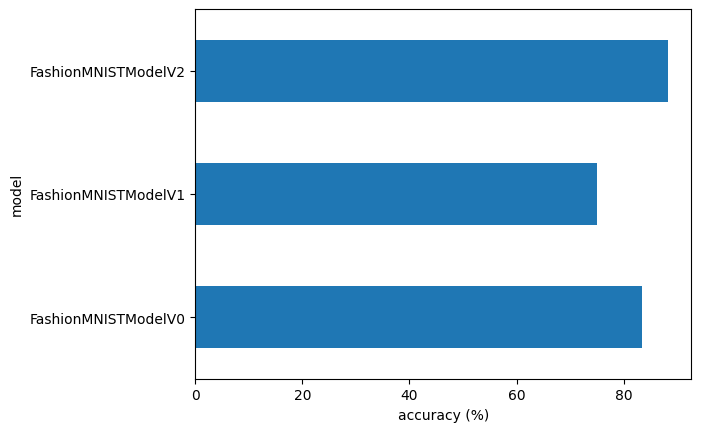

In [58]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and evaluate random predictions with the best model

In [59]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):

  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Pred_prob off GPU for further calculation
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

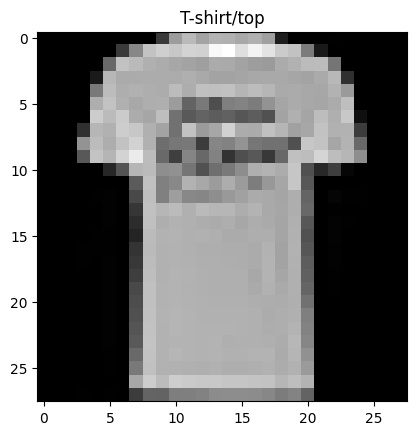

In [60]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

plt.imshow(test_samples[0].squeeze(), cmap = "gray");
plt.title(class_names[test_labels[0]]);

In [61]:
# Make predictions

pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# View the first two predictions probabilities
pred_probs[:2]

tensor([[9.9238e-01, 1.6796e-06, 6.9083e-04, 7.4229e-04, 1.3204e-05, 8.7807e-08,
         6.1542e-03, 4.3681e-07, 1.9897e-05, 4.2509e-08],
        [5.6564e-05, 9.9943e-01, 7.2022e-08, 4.3010e-04, 5.1533e-05, 2.9169e-07,
         2.0201e-05, 3.1561e-06, 6.8450e-06, 5.2931e-07]])

In [62]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([0, 1, 9, 4, 1, 9, 4, 3, 5])

In [63]:
test_labels

[0, 1, 9, 4, 1, 9, 4, 3, 5]

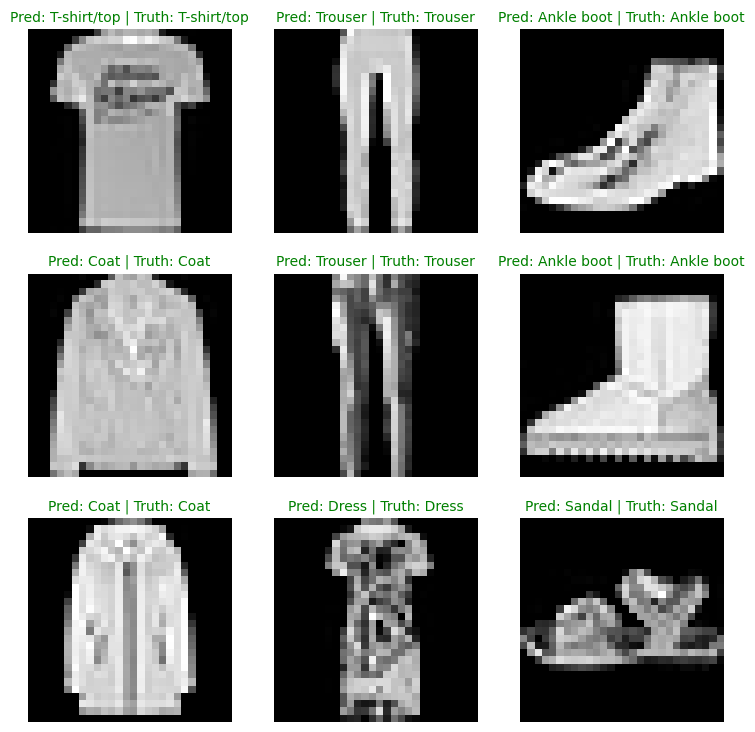

In [64]:
# Plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):

  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap = "gray")

  # Find the prediction
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change color of title test
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g")
  else:
    plt.title(title_text, fontsize = 10, c = "r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

1. Make predictions
2. Make a confusion matrix with `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlextend.plotting.plot_confusion_matrix()`

In [65]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = "Making predictions..."):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)

    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor, y_pred_tensor.shape

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1,  ..., 8, 1, 2]), torch.Size([10000]))

In [66]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version: 0.22.0


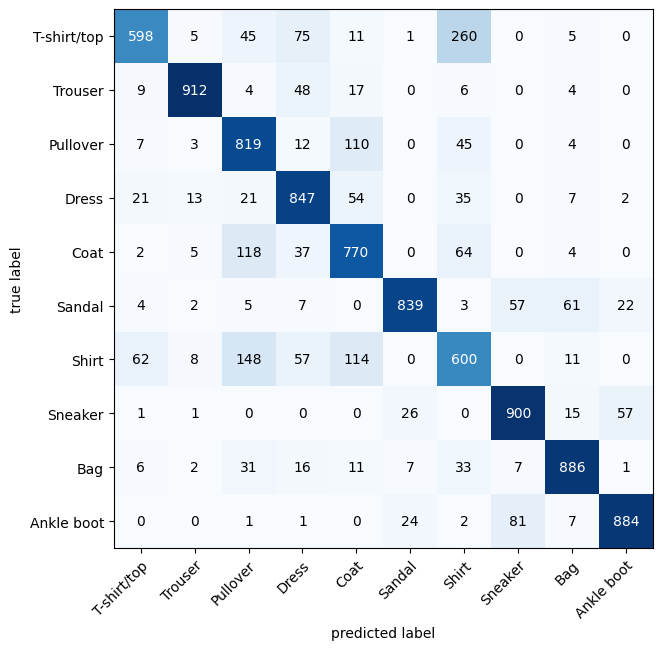

In [67]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize = (10, 7))

## 11. Save and load performing model



In [68]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents =T rue, exist_ok = True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [69]:
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
                                     hidden_units = 10,
                                     output_shape = len(class_names))

loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [70]:
model_2_results

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3216, 'model_acc': 88.26}

In [71]:
# Evaluate loaded model

torch.manual_seed(42)

loaded_model_2_results = eval_model(model = loaded_model_2,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn,
                                    device = device)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3216, 'model_acc': 88.26}

In [72]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol = 1e-08).item()

True